In [3]:
import pandas as pd
import numpy as np
import re
import copy

In [4]:
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
from matplotlib import pyplot

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
train_raw = pd.read_csv('data/train_df.csv')
test_raw = pd.read_csv('data/test_df.csv')

In [7]:
state_list = np.sort(train_raw['subregion1_code'].unique())

predictors = ' '.join(train_raw.columns)
mob_predictors = re.findall(r'mobility_\w+', predictors)
searchtrend_predictors = re.findall(r'search_trends_\w+', predictors)
ts_predictors = mob_predictors + searchtrend_predictors

pred_date = pd.date_range(start='2021-10-16', end='2021-11-05', freq='1D')
pred_date = pred_date.strftime('%Y-%m-%d').tolist()

forecast_date = pd.date_range(start='2021-11-06', end='2021-12-03', freq='1D')
forecast_date = forecast_date.strftime('%Y-%m-%d').tolist()

# Test on NY

In [44]:
#train_ny = train[train['subregion1_code']=='NY']
#train_ny['date'] =pd.to_datetime(train_ny['date'])
#train_ny = train_ny.reset_index(drop = True)

#test_ny = test[test['subregion1_code']=='NY']
#test_ny['date'] =pd.to_datetime(test_ny['date'])
#test_ny = test_ny.reset_index(drop = True)

# Time series prediction/forecast algorithm

In [158]:
for state in state_list:
    train_state = train_raw[train_raw['subregion1_code']==state]
    train_state['date'] =pd.to_datetime(train_state['date'])
    train_state = train_state.reset_index(drop = True)

    test_state = test_raw[test_raw['subregion1_code']==state]
    test_state['date'] =pd.to_datetime(test_state['date'])
    test_state = test_state.reset_index(drop = True)
    
    state_col = [state] * (len(pred_date)+len(forecast_date))
    pred_type = ['prediction'] * (len(pred_date))+ ['forecast'] *len(forecast_date)
    ts_pred_curr = pd.DataFrame(list(zip(state_col, pred_date + forecast_date, pred_type)),
                          columns =['subregion1_code', 'date', 'type'])

    
    for predictor in ts_predictors:
        train = train_state[predictor]
        test = test_state[predictor]
        
        if predictor in searchtrend_predictors:
        # detrend for mobility features
            train_set = train
            test_set = test  

            addf = adfuller(train_set)
            p_val = addf[1]

            # detrend by log shift if not stationary
            if p_val > 0.10:
                train_log = np.log(train_set)
                train_log_shift = train_log - train_log.shift()
                train_log_shift.dropna(inplace=True)
                train_df = train_log_shift

                test_set = pd.concat([pd.Series(train_set[len(train_set)-1]), test_set])
                test_log = np.log(test_set)

                test_log_shift = test_log - test_log.shift()
                test_log_shift.dropna(inplace=True)
                test_log_shift = test_log_shift.reset_index(drop = True)
                test_df = test_log_shift

            else:
                train_df = train_set
                test_df = test_set
        
        else:
        # detrend for mobility features
            train_set = train + 5000
            test_set = test + 5000
            train_log = np.log(train_set)

            test_set = pd.concat([pd.Series(train_set[len(train_set)-1]), test_set])
            test_log = np.log(test_set)

            train_df = train_log
            test_df = test_log

        best_aic = np.infty

        # find best parameters for ARIMA model
        for p in np.arange(5):
            for d in np.arange(3):
                for q in np.arange(5):
                    try:
                        m_ = ARIMA(train_df, order=(p, d, q)).fit()
                        aic_ = m_.aic
                        if aic_ < best_aic:
                            best_aic = aic_
                            best_order = (p, d, q)
                            best_m = m_
                    except:
                        pass

        history = [x for x in test_df]
        predictions = list()

        for t in range(len(pred_date)+len(forecast_date)):
            model = ARIMA(history, order=best_order)
            model_fit = model.fit()
            output = model_fit.forecast()
            predictions.append(output[0])
            history.append(history[t])
        
        if predictor in searchtrend_predictors:
            if p_val > 0.10:
                pred_diff = pd.Series(predictions, copy=True)
                pred_diff_cumsum = pred_diff.cumsum()
                pred_log = pd.Series(test_log.iloc[0], index=range(49))
                pred_log = pred_log.add(pred_diff_cumsum)
                pred_forecast = np.exp(pred_log)
            else:
                pred_forecast = predictions 
                
        else:
            pred_forecast = np.exp(predictions) - 5000

        ts_pred_curr[predictor] = pred_forecast
        
    ts_results = ts_results.append(ts_pred_curr)

In [132]:
ts_pred_curr

,subregion1_code,date,type,mobility_retail_and_recreation,mobility_grocery_and_pharmacy
0,OR,2021-10-16,prediction,2.921297,14.622644
1,OR,2021-10-17,prediction,3.549435,4.854704
2,OR,2021-10-18,prediction,3.340946,7.199651
3,OR,2021-10-19,prediction,3.884969,5.964833
4,OR,2021-10-20,prediction,4.225338,9.280067
5,OR,2021-10-21,prediction,3.411261,7.809391
6,OR,2021-10-22,prediction,3.786573,8.169322
7,OR,2021-10-23,prediction,2.898865,6.405934
8,OR,2021-10-24,prediction,1.672257,5.999269
9,OR,2021-10-25,prediction,0.471422,5.718957


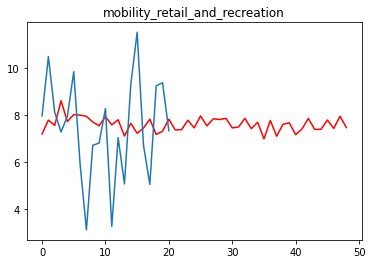

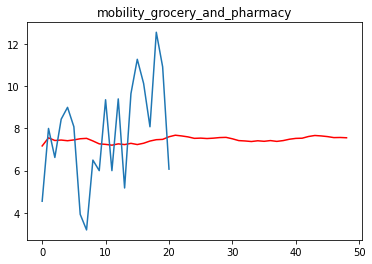

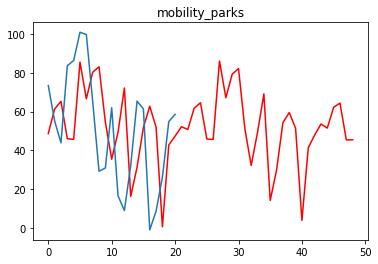

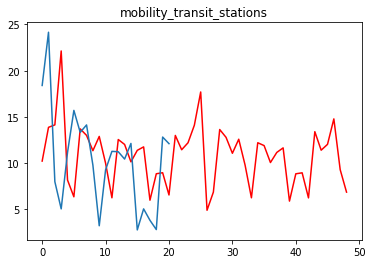

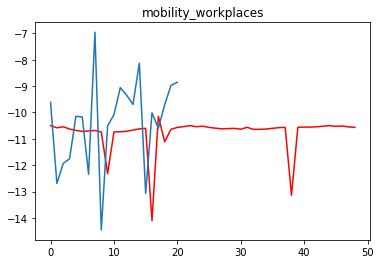

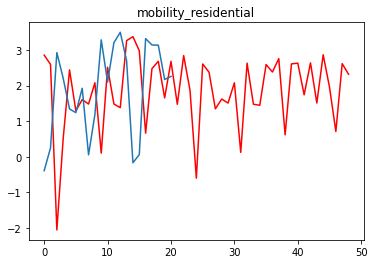

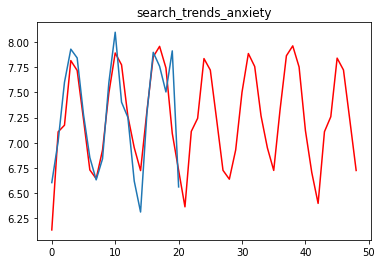

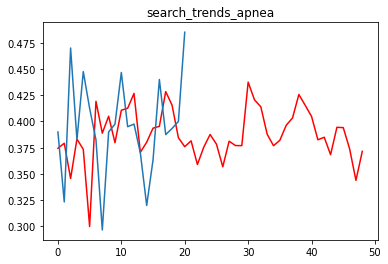

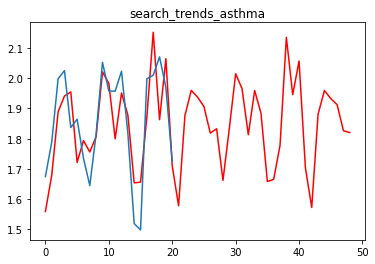

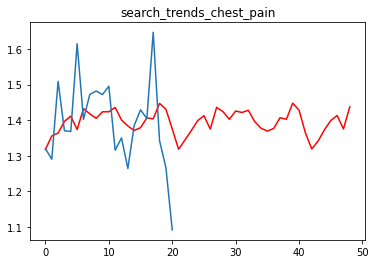

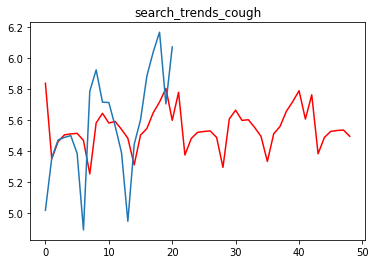

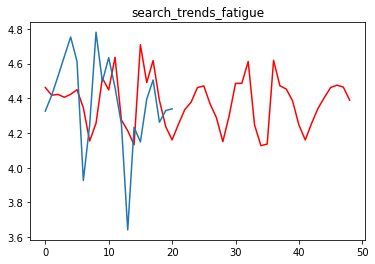

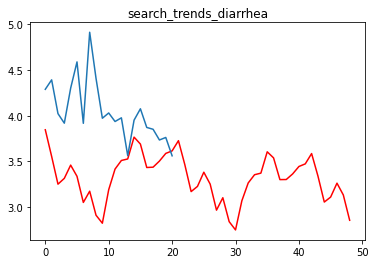

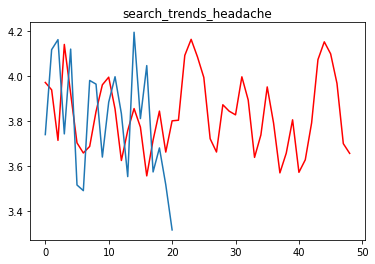

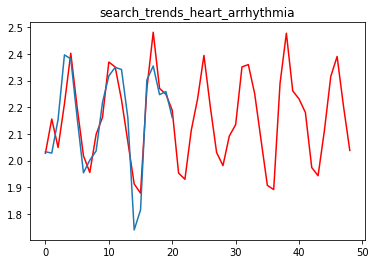

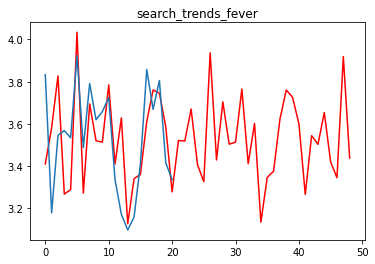

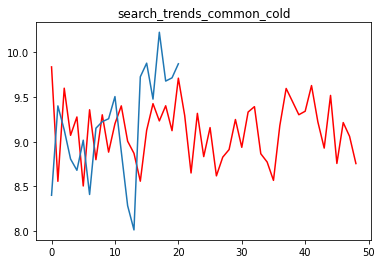

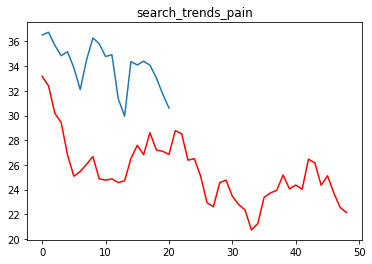

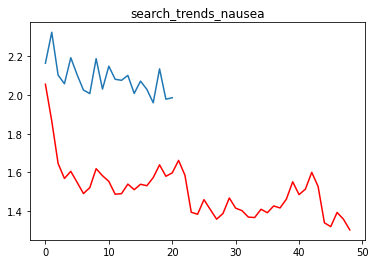

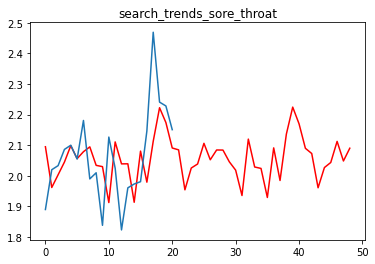

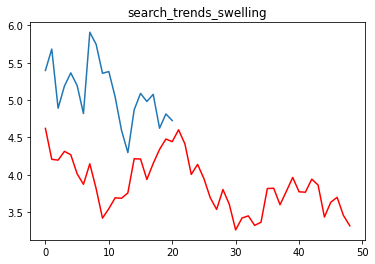

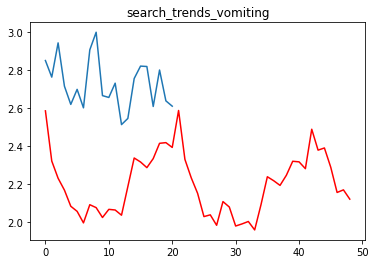

In [50]:
for pred in ts_predictors:
    plt.figure()
    plt.plot(plot_df[pred], c = 'red')
    plt.plot(test_state[pred])
    plt.title(pred)